# Import modules

In [1]:
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl')

%matplotlib inline

# Instatiate a grid from a DEM raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
# Instatiate a grid from a raster
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')

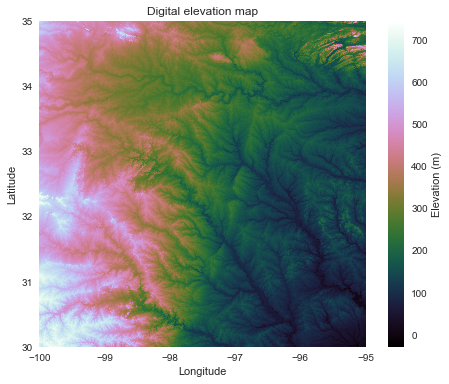

In [3]:
# Plot the raw DEM data
fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Read a flow direction grid from a raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [4]:
# Read a raster into the current grid
grid.read_raster('../data/n30w100_dir', data_name='dir')

# Examine grid

In [5]:
# The flow direction raster is contained in a named attribute (in memory)
grid.dir

Raster([[ 64,  64,  64, ...,   1,   2, 128],
        [ 32,  64,  64, ...,   1,   1, 128],
        [ 32,  32,  32, ...,   1, 128,  64],
        ...,
        [128,  64,  64, ...,  16,   8,   4],
        [128,  64,  64, ...,   4,  16,   4],
        [  8,  64,  64, ...,   8,   4,   4]], dtype=uint8)

In [6]:
# There are approximately 36 million grid cells
grid.dir.size

36000000

# Specify flow direction values

In [7]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Examine grid

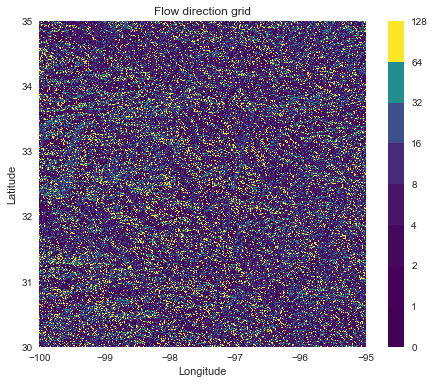

In [8]:
# Access the flow direction grid
fdir = grid.dir

# Plot the flow direction grid
fig = plt.figure(figsize=(8,6))
plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=1)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.title('Flow direction grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Delineate catchment

In [9]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [10]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [11]:
# Get a view of the catchment corresponding to the current bounding box
catch = grid.view('catch', nodata=np.nan)

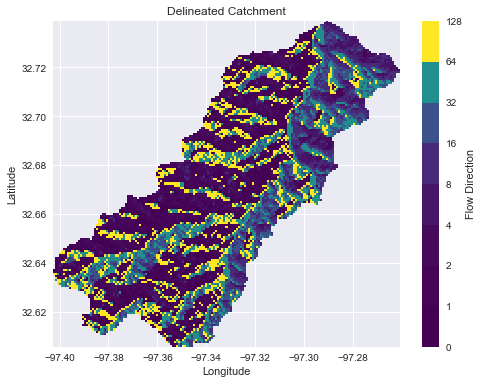

In [12]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap),
             label='Flow Direction')
plt.title('Delineated Catchment')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Get flow accumulation

In [13]:
# Compute flow accumulation at each cell
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

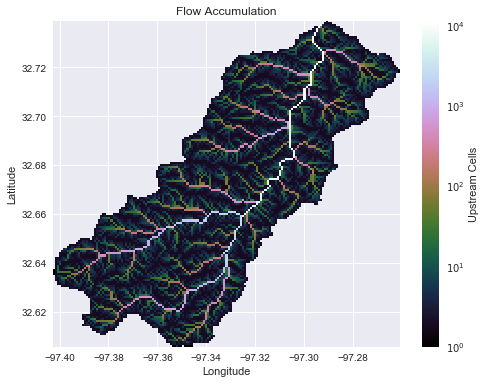

In [14]:
# Get a view and add 1 (to help with log-scaled colors)
acc = grid.view('acc', nodata=np.nan) + 1

# Plot the result
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(acc, extent=grid.extent, zorder=1,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Extract river network

In [15]:
# Extract branches for a given catchment
branches = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=50, dirmap=dirmap)

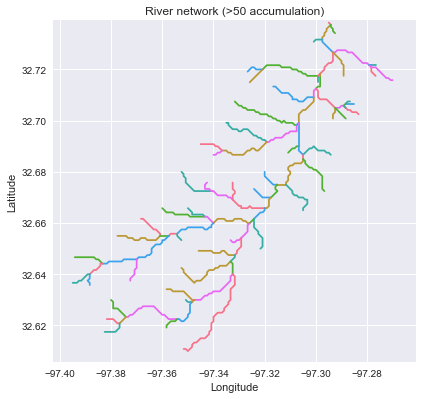

In [16]:
# Plot the result
fig, ax = plt.subplots(figsize=(6.5,6.5))
plt.title('River network (>50 accumulation)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

# Get distances to upstream cells

In [17]:
# Compute flow distance using graph traversal
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

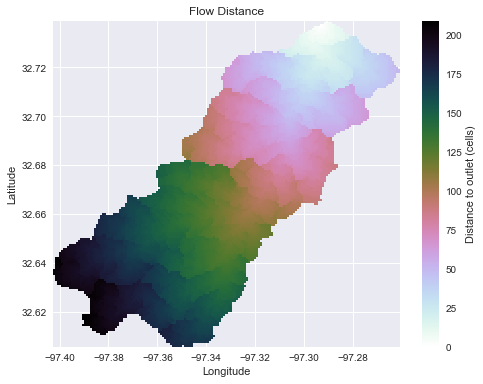

In [18]:
# Return a view of the flow distance grid
dist = grid.view('dist', nodata=np.nan)

# Plot the result
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(dist, extent=grid.extent, zorder=1,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.title('Flow Distance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Combine with land cover data

Data available here: https://www.mrlc.gov/nlcd2011.php

In [19]:
# Read land cover raster
grid.read_raster('../data/impervious_area/nlcd_2011_impervious_2011_edition_2014_10_10.img',
                 data_name='terrain', window=grid.bbox, window_crs=grid.crs)

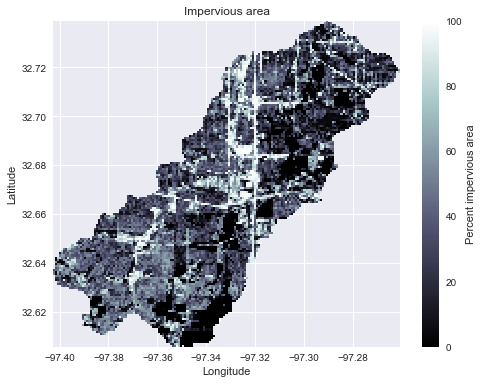

In [20]:
interpolated_terrain = grid.view('terrain', nodata=np.nan)

fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(interpolated_terrain, cmap='bone', zorder=1,
           extent=grid.extent)
plt.colorbar(label='Percent impervious area')
plt.title('Impervious area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Clip soils shapefile to catchment

Data available here: https://tnris.org/data-download/#!/county/Tarrant

In [21]:
# Read soil dataset
soils = gpd.read_file('../data/nrcs-soils/nrcs-soils-tarrant_439.shp')
soil_id = 'MUKEY'
# Convert catchment raster to vector geometry and find intersection
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape)
                                     for shape, value in shapes])
soils = soils[soils.intersects(catchment_polygon)]
catchment_soils = gpd.GeoDataFrame(soils[soil_id],
                                   geometry=(soils.geometry
                                             .intersection(catchment_polygon)))
# Convert soil types to consecutive integer values
soil_types = np.unique(catchment_soils[soil_id])
soil_types = pd.Series(np.arange(soil_types.size), index=soil_types)
catchment_soils[soil_id] = catchment_soils[soil_id].map(soil_types)

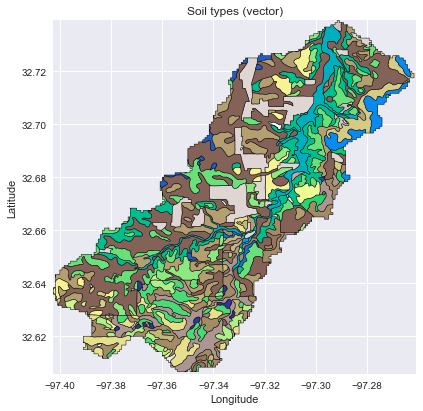

In [22]:
# Plot the result
fig, ax = plt.subplots(figsize=(6.5, 6.5))
catchment_soils.plot(ax=ax, column=soil_id, categorical=True,
                     cmap='terrain', linewidth=0.5, alpha=1)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Soil types (vector)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Rasterize soil data in catchment

In [23]:
# Rasterize the soil polygons
soil_polygons = zip(catchment_soils.geometry.values,
                    catchment_soils[soil_id].astype(int).values)
soil_raster = grid.rasterize(soil_polygons, fill=np.nan)

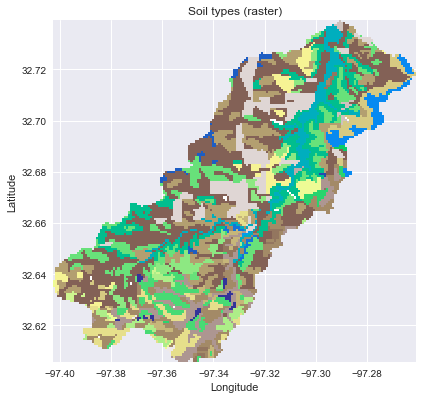

In [24]:
# Plot the result
fig, ax = plt.subplots(figsize=(6.5, 6.5))
plt.imshow(soil_raster, cmap='terrain', extent=grid.extent, zorder=1)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Soil types (raster)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')